# Forrest Fire (Protugal) prediction using SVR, Random Forest, and Deep NN

This dataset is public available for research. The details are described in [Cortez and Morais, 2007]. Please include this citation if you plan to use this database:

P. Cortez and A. Morais. ***A Data Mining Approach to Predict Forest Fires using Meteorological Data.*** 
In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. 
  
Available at: http://www.dsi.uminho.pt/~pcortez/fires.pdf

For more information, read [Cortez and Morais, 2007].

* X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
* Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
* month - month of the year: "jan" to "dec" 
* day - day of the week: "mon" to "sun"
* FFMC - FFMC index from the FWI system: 18.7 to 96.20
* DMC - DMC index from the FWI system: 1.1 to 291.3 
* DC - DC index from the FWI system: 7.9 to 860.6 
* ISI - ISI index from the FWI system: 0.0 to 56.10
* temp - temperature in Celsius degrees: 2.2 to 33.30
* RH - relative humidity in %: 15.0 to 100
* wind - wind speed in km/h: 0.40 to 9.40 
* rain - outside rain in mm/m2 : 0.0 to 6.4 
* area - the burned area of the forest (in ha): 0.00 to 1090.84

**As we will see this is a extremely hard regression problem with clear outliers which cannot be predicted using any reasonable method. Four methods: (a) support vector regression, (b) decision tree, (c) random forest, (d) 3-layer dense neural network will be tried to show the relative performance.**

In [595]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read the Forest Fire dataset

In [596]:
df = pd.read_csv('./Datasets/forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Basic statistics and visualization of the dataset

#### Describe the statistics of numerical columns

In [597]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


#### Plot scatterplots and distributions of numerical features to see how they may affect the output 'area'

For this, first we need to transform the outcome 'area' by taking its logarithm (after adding 1 to avoid zeros)

$$\text{Log-area} = log_{10}(area+1)$$

In [598]:
df['Log-area']=np.log10(df['area']+1)

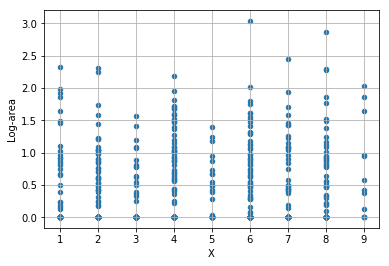

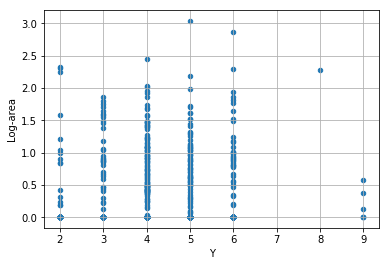

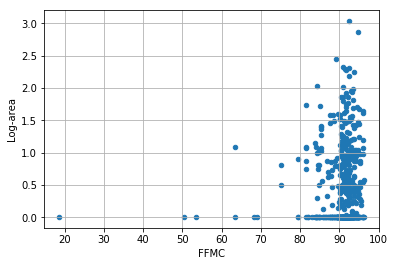

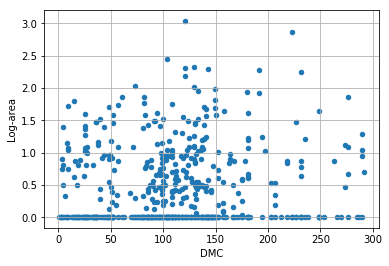

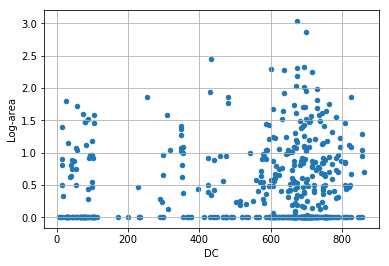

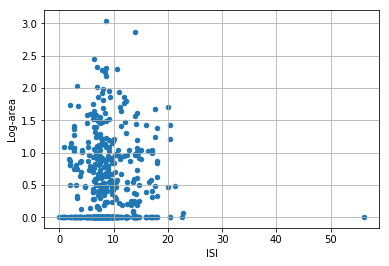

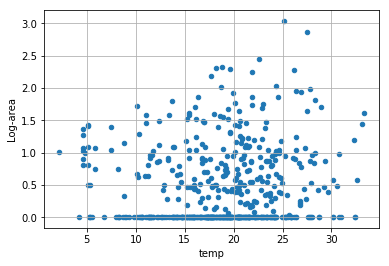

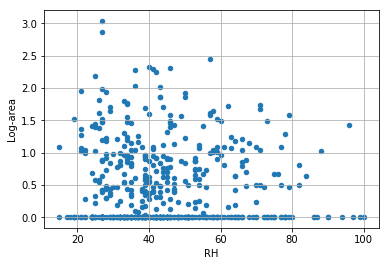

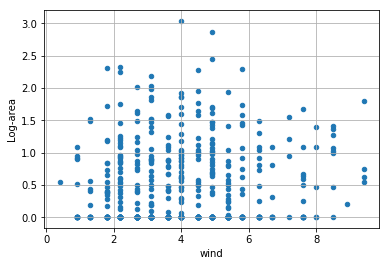

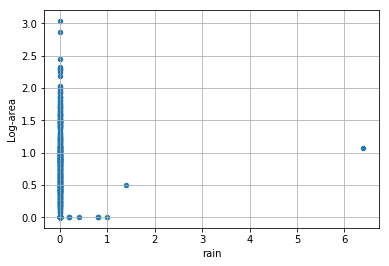

In [599]:
for i in df.describe().columns[:-2]:
    df.plot.scatter(i,'Log-area',grid=True)

#### Plot boxplots of how the categorical features (month and day) affect the outcome

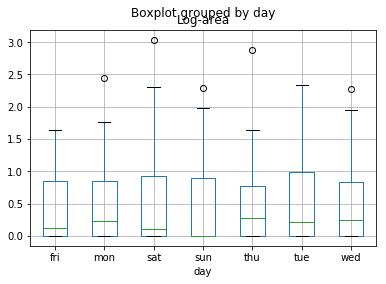

In [600]:
df.boxplot(column='Log-area',by='day')

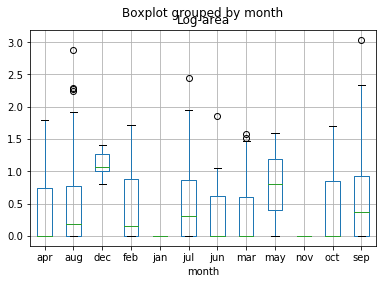

In [601]:
df.boxplot(column='Log-area',by='month')

## Data pre-processing, test/train split, REC function

In [602]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [603]:
enc = LabelEncoder()
enc.fit(df['month'])

LabelEncoder()

In [604]:
enc.classes_

array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object)

In [605]:
df['month_encoded']=enc.transform(df['month'])
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Log-area,month_encoded
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,7
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,10
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,10
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,7
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,7


In [606]:
enc.fit(df['day'])
df['day_encoded']=enc.transform(df['day'])
df.head(15)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Log-area,month_encoded,day_encoded
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,7,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,10,5
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,10,2
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,7,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,7,3
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0,0.0,1,3
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0,0.0,1,1
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0,0.0,1,1
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0,0.0,11,5
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0,0.0,11,2


In [607]:
X_data=df.drop(['area','Log-area','month','day'],axis=1)
y_data=df['Log-area']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4)

In [608]:
y_train=y_train.reshape(y_train.size,1)

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


### Regression Error Characteristic (REC) estimation

Receiver Operating Characteristic (ROC) curves provide a powerful tool for visualizing and comparing classification results. Regression Error Characteristic (REC) curves generalize ROC curves to regression. REC curves plot the error tolerance on the $x-axis$ versus the percentage of points predicted within the tolerance on the $y-axis$. The resulting
curve estimates the cumulative distribution function of the error. The REC curve visually presents commonly-useds tatistics. The area-over-the-curve (AOC) is a biased estimate of the expected error. The $R^2$ value can be estimated using the ratio of the AOC for a given model to the AOC for the nul-model. Users can quickly assess the relative
merits of many regression functions by examining the relative position of their REC curves. The shape of the curve reveals additional information that can be used to guide modeling.

[Check this paper for more details](https://www.aaai.org/Papers/ICML/2003/ICML03-009.pdf)

In [609]:
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

In [610]:
# Define the max tolerance limit for REC curve x-axis
# For this problem this represents the absolute value of error in the prediction of the outcome i.e. area burned
tol_max=20

## SVR

In [611]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [612]:
scaler = StandardScaler()
param_grid = {'C': [0.01,0.1,1, 10], 'epsilon': [10,1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
grid_SVR = GridSearchCV(SVR(),param_grid,refit=True,verbose=0)
grid_SVR.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'epsilon': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [613]:
grid_SVR.best_params_

{'C': 0.01, 'epsilon': 1, 'kernel': 'rbf'}

In [614]:
a=grid_SVR.predict(X_test)
print("RMSE for Support Vector Regression:",np.sqrt(np.mean((y_test-a)**2)))

RMSE for Support Vector Regression: 0.694469691298


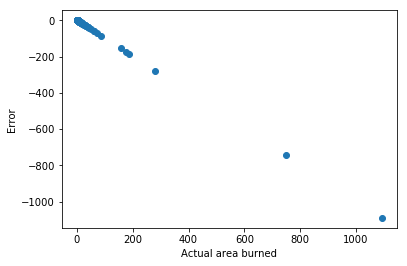

In [615]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.scatter(10**(y_test),10**(a)-10**(y_test))

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    2.,    1.,    0.,    0.,
           0.,    2.,    3.,   12.,  184.]),
 array([ -1.09029076e+03,  -1.06847396e+03,  -1.04665716e+03,
         -1.02484036e+03,  -1.00302356e+03,  -9.81206764e+02,
         -9.59389964e+02,  -9.37573164e+02,  -9.15756364e+02,
         -8.93939564e+02,  -8.72122764e+02,  -8.50305964e+02,
         -8.28489164e+02,  -8.06672364e+02,  -7.84855564e+02,
         -7.63038764e+02,  -7.41221964e+02,  -7.19405164e+02,
         -6.97588364e+02,  -6.75771564e+02,  -6.53954764e+02,
         -6.32137964e+02,  -6.10321164e+02,  -5.88504364e+02,
         -5.66687564e+02,  -5.44870764e+02,  -5.23053964e+02,
         -5.01237164e+02,  -4.79420364e+02

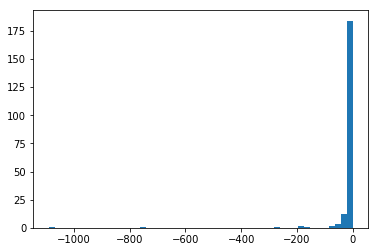

In [616]:
plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

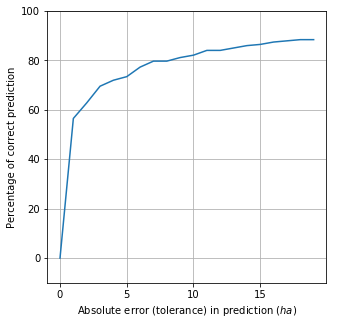

In [617]:
rec_SVR=[]
for i in range(tol_max):
    rec_SVR.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_SVR)

## Decision Tree Regressor

In [618]:
from sklearn.tree import DecisionTreeRegressor

In [619]:
tree_model = DecisionTreeRegressor(max_depth=10,criterion='mae')
tree_model.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))

DecisionTreeRegressor(criterion='mae', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [620]:
a=tree_model.predict(X_test)
print("RMSE for Decision Tree:",np.sqrt(np.mean((y_test-a)**2)))

RMSE for Decision Tree: 0.649000125851


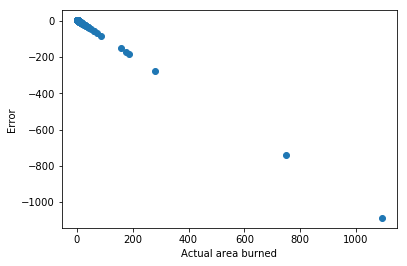

In [621]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.scatter(10**(y_test),10**(a)-10**(y_test))

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    2.,    1.,    0.,    0.,
           0.,    2.,    3.,   12.,  184.]),
 array([-1087.40624139, -1065.58944139, -1043.77264139, -1021.95584139,
        -1000.13904139,  -978.32224139,  -956.50544139,  -934.68864139,
         -912.87184139,  -891.05504139,  -869.23824139,  -847.42144139,
         -825.60464139,  -803.78784139,  -781.97104139,  -760.15424139,
         -738.33744139,  -716.52064139,  -694.70384139,  -672.88704139,
         -651.07024139,  -629.25344139,  -607.43664139,  -585.61984139,
         -563.80304139,  -541.98624139,  -520.16944139,  -498.35264139,
         -476.53584139,  -454.71904139,  -432.90224139,  -411.08544139,
         -389.26864139, 

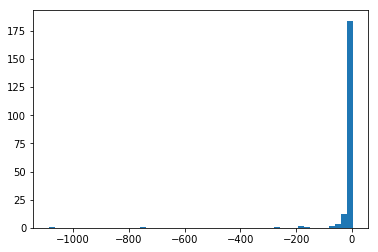

In [622]:
plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

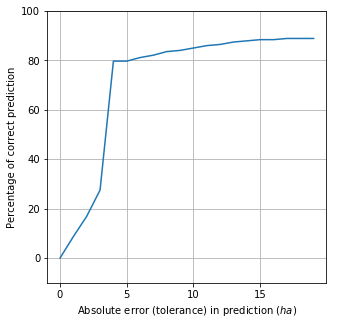

In [623]:
rec_DT=[]
for i in range(tol_max):
    rec_DT.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_DT)

## Random Forest Regressor

In [624]:
from sklearn.ensemble import RandomForestRegressor

In [625]:
rf_model = RandomForestRegressor(criterion='mae',n_estimators=500,max_depth=5,
                                 max_features='log2',min_samples_split=10,min_samples_leaf=5)
param_grid = {'max_depth': [5,10,15,20,50], 'max_leaf_nodes': [2,5,10], 'min_samples_leaf': [2,5,10],
             'min_samples_split':[2,5,10]}
grid_RF = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=0)
grid_RF.fit(X_train,y_train)

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Tirtha\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:437: DataConvers

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15, 20, 50], 'max_leaf_nodes': [2, 5, 10], 'min_samples_leaf': [2, 5, 10], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [626]:
grid_RF.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [627]:
a=grid_RF.predict(X_test)
rmse_rf=np.sqrt(np.mean((y_test-a)**2))
print("RMSE for Random Forest:",rmse_rf)

RMSE for Random Forest: 0.628875085266


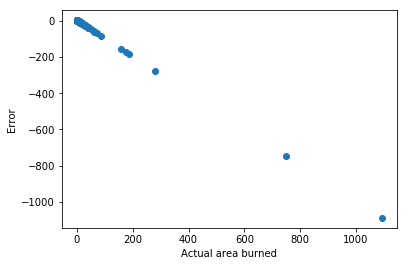

In [628]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.scatter(10**(y_test),10**(a)-10**(y_test))

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    2.,    1.,    0.,    0.,
           1.,    1.,    4.,   11.,  184.]),
 array([-1088.7195495 , -1066.88206613, -1045.04458276, -1023.20709938,
        -1001.36961601,  -979.53213264,  -957.69464926,  -935.85716589,
         -914.01968252,  -892.18219914,  -870.34471577,  -848.5072324 ,
         -826.66974902,  -804.83226565,  -782.99478228,  -761.1572989 ,
         -739.31981553,  -717.48233215,  -695.64484878,  -673.80736541,
         -651.96988203,  -630.13239866,  -608.29491529,  -586.45743191,
         -564.61994854,  -542.78246517,  -520.94498179,  -499.10749842,
         -477.27001505,  -455.43253167,  -433.5950483 ,  -411.75756493,
         -389.92008155, 

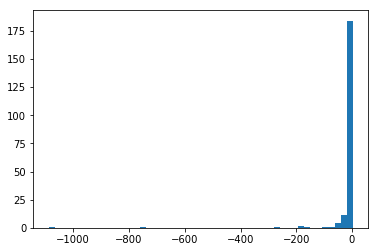

In [629]:
plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

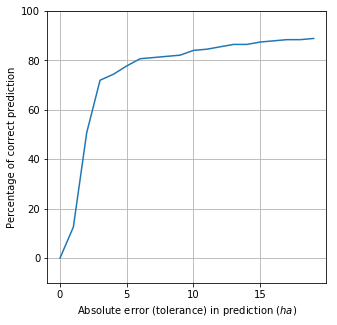

In [630]:
rec_RF=[]
for i in range(tol_max):
    rec_RF.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_RF)

## Deep network (using Keras)

In [631]:
from keras.models import Sequential
import keras.optimizers as opti
from keras.layers import Dense, Activation,Dropout

In [632]:
model = Sequential()
model.add(Dense(100, input_dim=12))
model.add(Activation('selu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Activation('selu'))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 100)               1300      
_________________________________________________________________
activation_47 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
activation_48 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 50)                5050      
__________

In [633]:
learning_rate=0.001
optimizer = opti.RMSprop(lr=learning_rate)

In [634]:
model.compile(optimizer=optimizer,loss='mse')

In [635]:
data=X_train
target = y_train
model.fit(data, target, epochs=100, batch_size=10,verbose=0)

In [636]:
a=model.predict(X_test)
print("RMSE for Deep Network:",np.sqrt(np.mean((y_test-a.reshape(a.size,))**2)))

RMSE for Deep Network: 0.639929668627


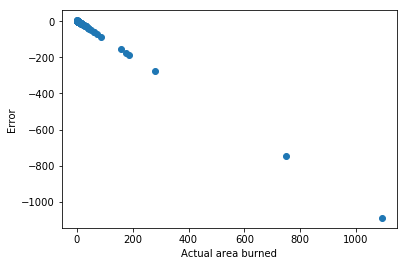

In [637]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.scatter(10**(y_test),10**(a.reshape(a.size,))-10**(y_test))

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    2.,    1.,    0.,    0.,
           1.,    2.,    3.,   13.,  182.]),
 array([-1089.20468196, -1067.30512028, -1045.40555859, -1023.50599691,
        -1001.60643523,  -979.70687354,  -957.80731186,  -935.90775017,
         -914.00818849,  -892.10862681,  -870.20906512,  -848.30950344,
         -826.40994176,  -804.51038007,  -782.61081839,  -760.71125671,
         -738.81169502,  -716.91213334,  -695.01257166,  -673.11300997,
         -651.21344829,  -629.31388661,  -607.41432492,  -585.51476324,
         -563.61520156,  -541.71563987,  -519.81607819,  -497.91651651,
         -476.01695482,  -454.11739314,  -432.21783146,  -410.31826977,
         -388.41870809, 

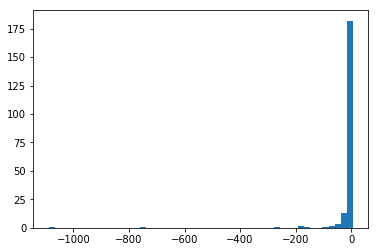

In [638]:
plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

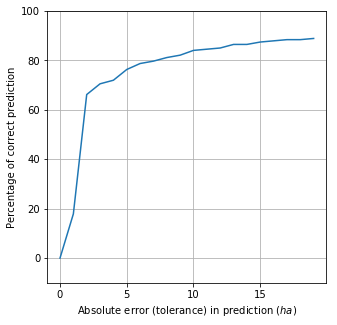

In [639]:
rec_NN=[]
for i in range(tol_max):
    rec_NN.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_NN)

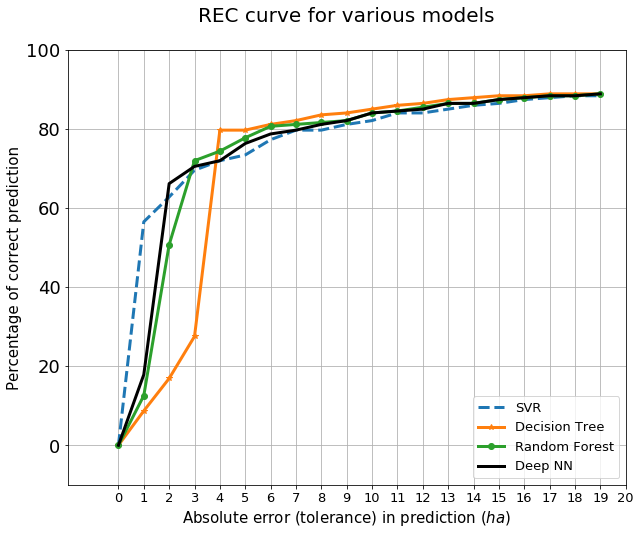

In [645]:
plt.figure(figsize=(10,8))
plt.title("REC curve for various models\n",fontsize=20)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)",fontsize=15)
plt.ylabel("Percentage of correct prediction",fontsize=15)
plt.xticks([i for i in range(0,tol_max+1,1)],fontsize=13)
plt.ylim(-10,100)
plt.xlim(-2,tol_max)
plt.yticks([i*20 for i in range(6)],fontsize=18)
plt.grid(True)
plt.plot(range(tol_max),rec_SVR,'--',lw=3)
plt.plot(range(tol_max),rec_DT,'*-',lw=3)
plt.plot(range(tol_max),rec_RF,'o-',lw=3)
plt.plot(range(tol_max),rec_NN,'k-',lw=3)
plt.legend(['SVR','Decision Tree','Random Forest','Deep NN'],fontsize=13)